In [22]:
import pyemma as pm
import mdtraj as md
from molpx.generate import projection_paths
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from typing import Dict, Union, List
from msmsense.featurizers import dihedrals, distances
from msmsense.bootstrap_cmatrices import get_sub_dict, get_trajs
from functools import partial

%matplotlib inline

import pickle
import time

In [23]:
def get_feature_dict(df, row_num):
    row_dict = df.filter(regex='__', axis=1).loc[row_num, :].to_dict()
    feature_dict = get_sub_dict(row_dict, 'feature')
    if feature_dict['value'] == 'distances':
        feature_dict.update(get_sub_dict(row_dict, 'distances'))
    if feature_dict['value'] == 'dihedrals':
        feature_dict.update(get_sub_dict(row_dict, 'dihedrals'))
    return feature_dict

def get_kws_dict(df, row_num, kws):
    row_dict = df.filter(regex='__', axis=1).loc[row_num, :].to_dict()   
    kws_dict = get_sub_dict(row_dict, kws)
    return kws_dict

def set_proper_dtypes(df):
    """
    forgot to save integers as integers. Only the distances feature columns have true floats. 
    """
    potential_integer_cols = df.columns.difference(list(df.filter(regex='distances.*', axis=1)))
    for col in potential_integer_cols:
        if str(df[col].dtype) != 'object':
            df[col] = df[col].astype(int)
    return df

def get_trajs_top(traj_dir: Path, protein_dir: str, rng: Union[np.random.Generator, None]=None):
    trajs = list(traj_dir.rglob(f"*{protein_dir.upper()}*/*.xtc"))
    trajs.sort()
    
    if rng is not None:
        ix = rng.choice(np.arange(len(trajs)), size=10, replace=True)
        trajs = [trajs[i] for i in ix]
    
    top = list(traj_dir.rglob(f"*{protein_dir.upper()}*/*.pdb"))[0]
    
    return {'trajs': trajs, 'top': top}
    

In [76]:
class MSM(object):
    
    def __init__(self, lag: int, num_evs: int, trajs: List[md.Trajectory], top: md.Trajectory,
                 feature_kws: Dict[str, Union[str, int, float]], tica_kws: Dict[str, Union[str, int, float]], cluster_kws: Dict[str, Union[str, int, float]]):
        """
        Defines the whole MSM pipeline.
        lag: markov lag time 
        num_evs: number of eigenvectors in VAMP score. This includes stationary distribution. note: all projections are done onto the processes 1 - num_evs, i.e., exclude the stationary distribution (process 0)
        traj_top_paths: dictionary with 'trajs' - list of Paths to trajectories, and 'top' Path to topology file. 
        
        """
        self.lag = lag
        self.num_evs = num_evs
        self.trajs = trajs
        self.top = top
        self.feature_kws = feature_kws
        self.tica_kws = tica_kws
        self.cluster_kws = cluster_kws
        self.featurizer = None
        self._set_featurizer()
        
        self.tica = None
        self.cluster = None
        self.msm = None
        self.paths = None
        
    def _set_featurizer(self):
        feature_kws = self.feature_kws.copy()
        feature = feature_kws.pop('value')
        
        if feature == 'distances':
            self.featurizer = partial(distances, **feature_kws)
        elif feature == 'dihedrals':
            self.featurizer = partial(dihedrals, **feature_kws)
        else:
            raise NotImplementedError('Unrecognized feature')
        

    def fit(self):
        ftrajs = self.featurizer(self.trajs)
        self.tica = pm.coordinates.tica(data=ftrajs, **self.tica_kws)
        ttrajs = self.tica.get_output()
        self.cluster = pm.coordinates.cluster_kmeans(data=ttrajs, **self.cluster_kws)
        dtrajs = self.cluster.dtrajs
        self.msm = pm.msm.estimate_markov_model(dtrajs=dtrajs, lag=self.lag)

    
    def _get_all_projections(self, num_procs: int, dtrajs: List[np.ndarray]) -> np.ndarray:
        """ Project dtrajs onto first num_proc eigenvectors excluding stationary distribution. i.e., if num_proc=1 then project onto the slowest eigenvector only. 
        All projections ignore the stationary distribution
        """
        evs = self.msm.eigenvectors_left(num_procs+1)
        active_set = self.msm.active_set
        NON_ACTIVE_PROJ_VAL = 0 # if the state is not in the active set, set the projection to this value. 
        NON_ACTIVE_IX_VAL = -1
        evs = evs[1:, :] # remove the stationary distribution
        proj_trajs = []
        for dtraj in dtrajs:
            all_procs = []
            for proc_num in range(num_procs):
                
                tmp = np.ones(dtraj.shape[0], dtype=float)
                tmp[:] = NON_ACTIVE_PROJ_VAL
                
                for i in range(dtraj.shape[0]):
                    x = self.msm._full2active[dtraj[i]]
                    if x != NON_ACTIVE_IX_VAL:
                        tmp[i] = evs[proc_num, x]
                    tmp = tmp.reshape(-1, 1)
                
                all_procs.append(tmp)
            all_procs = np.concatenate(all_procs, axis=1)
            proj_trajs.append(all_procs)
        
        return proj_trajs
        
        
    def projection_paths(self, n_projs: Union[None, int]=None, proj_dim: Union[None, int]=None, n_points: int=100, n_geom_samples: int=100):
        """
        n_projs: number of paths to create. Default = None = num_evs - 1 (i.e., exclude stationary distribution)
        proj_dim: dimensionality of the space in which distances will be computed. Default = None = num_evs - 1 (i.e., exclude stationary distribution)
        n_points: number of points along the path (there may be less than this.)
        n_geom_samples: For each of the n_points along the projection path, n_geom_samples will be retrieved from the trajectory files. 
                        The higher this number, the smoother the minRMSD projection path. Also, the longer it takes for the path to be computed
        """
        
        if proj_dim is None:
            proj_dim = self.num_evs - 1
        if n_projs is None:
            n_projs = self.num_evs - 1
        
        projections = self._get_all_projections(num_procs=proj_dim, dtrajs=self.msm.discrete_trajectories_active)
        
        paths, _ = projection_paths(MD_trajectories=self.trajs, MD_top = self.top, projected_trajectories=projections, 
                                    n_projs=n_projs, proj_dim=proj_dim, n_geom_samples=n_geom_samples, n_points=n_points)
        self.paths = paths
        
        
    
    def get_projection_trajectory(self, proc_num: int, kind: str='min_rmsd') -> md.Trajectory:
        """
        Returns the projection trajectory for a specific dimension
        proc_num: the number process. Min value = 1
        """
        if proc_num == 0:
            raise ValueError("process_num must be >=1. Processes are indexed from 0 (stationary distribution). Process 1 is the slowest projected process.")
            
        return self.paths[proc_num-1][kind]['geom']
    
    
    def transform(self, new_trajectory: md.Trajectory) -> np.ndarray:
        """
        projects new trajectory onto the self.num_proc eigenvectors of the MSM
        """
        ftrajs = self.featurizer([new_trajectory])
        ttrajs = self.tica.transform(ftrajs)
        dtrajs = self.cluster.transform(ttrajs)
        projections = self._get_all_projections(num_procs=self.num_evs - 1, dtrajs=dtrajs)
        return projections
        
        
    

In [87]:
traj_dir = Path('/Volumes/REA/MD/12FF/strided/')
protein_dir = '1FME'
out_dir = Path('/Volumes/REA/Data/fast_folders/model_comparisons/').joinpath(protein_dir)
out_dir.mkdir(exist_ok=True, parents=True)
comparator_ix = 0 # Always best because of sorting. 
num_bs_iter = 5
n_points = 50 # points along path
n_geom_samples = 50 # samples to create min rmsd

In [88]:

mod_defs = set_proper_dtypes(pd.read_hdf('../results/best_hps_per_feature.h5', key='best_hps_per_feature'))
mod_defs = mod_defs.loc[mod_defs.protein_dir==protein_dir.lower(), :]
mod_defs.sort_values(by=['protein', 'hp_rank'], inplace=True)
mod_defs.reset_index(inplace=True, drop=True)

In [89]:
mod_defs.to_hdf(out_dir.joinpath('model_definitions.h5'), key='model_definitions')

In [90]:
rng = np.random.default_rng(12098345)

for bs_num in range(num_bs_iter):
    print('BS iteration ', bs_num)
    tic = time.time()
    
    
    # Create output directory
    iter_out_dir = out_dir.joinpath(f"iter_{bs_num}")
    iter_out_dir.mkdir(exist_ok=True)

    # Sample traj paths and save results
    traj_paths = get_trajs_top(traj_dir, protein_dir, rng)
    assert len(traj_paths['trajs']) > 0, 'no trajectories found'
    pickle.dump(file=iter_out_dir.joinpath('input_paths.pkl').open('wb'), obj=traj_paths)

    top = md.load(str(traj_paths['top']))
    trajs = [md.load(str(x), top=top) for x in traj_paths['trajs']]
    print('\tfinished loading trajectories')
    
    # Fit models and find paths
    models = {}
    for row_num in mod_defs.index:
        print('Model num ', row_num)
        hp_ix = mod_defs.hp_index[row_num]
        hp_rank = mod_defs.hp_rank[row_num]
        
        # model hyperparameters
        lag = mod_defs.lag[row_num]
        num_evs = mod_defs.k[row_num]
        feat_kws = get_feature_dict(mod_defs, row_num)
        tica_kws = get_kws_dict(mod_defs, row_num, 'tica')
        cluster_kws = get_kws_dict(mod_defs, row_num, 'cluster')

        # Fit model
        model = MSM(lag = lag, num_evs=num_evs, trajs=trajs, top=top,  feature_kws=feat_kws, tica_kws=tica_kws, cluster_kws=cluster_kws)
        model.fit()
        print('\tfinished fitting model')
        # Estimate all paths
        
        model.projection_paths(n_points=n_points, n_geom_samples=n_geom_samples)
        print('\tfinished projecting paths')
        pickle.dump(file=iter_out_dir.joinpath(f"mod_{row_num}_hp_{hp_ix}_rank_{hp_rank}_paths.pkl").open('wb'), obj=model.paths)
        print('\tfinished dumping paths')
        # Accumulate models for comparisons
        models[row_num] = model
    
    
    # Do model comparisons
    for proc_num in list(models[comparator_ix].paths.keys()):  # shouldn't matter which model is used here. 
        print('\tcomparing path ', proc_num)
        paths = {k: v.get_projection_trajectory(proc_num+1) for k, v in models.items()}
        projs = {f"mod_{k}_on_mod_{comparator_ix}": models[comparator_ix].transform(v)[0] for k, v in paths.items()}
        pickle.dump(file=iter_out_dir.joinpath(f'path_{proc_num}_comparison.pkl').open('wb'), obj=projs)
        
    print((time.time() - tic)/60)

BS iteration  0
	finished loading trajectories
Model num  0


calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

	finished fitting model


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at 0.000892936 diffuses 0.00507244 in 3D proj-space
	 most_pop  finished  0.01352833112080892
Strategy smallest_Rgyr starting at -0.00341123 diffuses 0.00502331 in 3D proj-space
	 smallest_Rgyr  finished  0.011997401714324951
Strategy most_pop_x_smallest_Rgyr starting at 0.00033262 diffuses 0.00492101 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.013706612586975097
Strategy bimodal_compact starting at -0.0273901 diffuses 0.0045504 in 3D proj-space
	 bimodal_compact  finished  0.012230817476908367
Sticking with bimodal_compact


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at 0.0224877 diffuses 0.0139116 in 3D proj-space
	 most_pop  finished  0.013172916571299235
Strategy smallest_Rgyr starting at 0.00168703 diffuses 0.0139888 in 3D proj-space
	 smallest_Rgyr  finished  0.01263258457183838
Strategy most_pop_x_smallest_Rgyr starting at 0.0224877 diffuses 0.0139116 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.014190769195556641
Strategy bimodal_compact starting at 0.0159867 diffuses 0.0170017 in 3D proj-space
	 bimodal_compact  finished  0.012267514069875082
Sticking with most_pop


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at 0.0041847 diffuses 0.0176509 in 3D proj-space
	 most_pop  finished  0.011872537930806478
Strategy smallest_Rgyr starting at 0.00117461 diffuses 0.0172713 in 3D proj-space
	 smallest_Rgyr  finished  0.01460576852162679
Strategy most_pop_x_smallest_Rgyr starting at 0.0041847 diffuses 0.0176509 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.01253211498260498
Strategy bimodal_compact starting at 0.00147488 diffuses 0.0182288 in 3D proj-space
	 bimodal_compact  finished  0.014460619290669758
Sticking with smallest_Rgyr
	finished projecting paths
	finished dumping paths
Model num  1


calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

	finished fitting model


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at -0.00022354 diffuses 0.0028352 in 3D proj-space
	 most_pop  finished  0.013195582230885823
Strategy smallest_Rgyr starting at -0.00816378 diffuses 0.00318292 in 3D proj-space
	 smallest_Rgyr  finished  0.011911797523498534
Strategy most_pop_x_smallest_Rgyr starting at -0.00022354 diffuses 0.0028352 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.013758997122446695
Strategy bimodal_compact starting at -0.0243844 diffuses 0.00310495 in 3D proj-space
	 bimodal_compact  finished  0.012525566418965657
Sticking with most_pop


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at -0.0207219 diffuses 0.0127868 in 3D proj-space
	 most_pop  finished  0.013840881983439128
Strategy smallest_Rgyr starting at -0.00400158 diffuses 0.0127972 in 3D proj-space
	 smallest_Rgyr  finished  0.012266600131988525
Strategy most_pop_x_smallest_Rgyr starting at -0.0207219 diffuses 0.0127868 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.014332985877990723
Strategy bimodal_compact starting at -0.0207219 diffuses 0.0127868 in 3D proj-space
	 bimodal_compact  finished  0.012110904852549235
Sticking with bimodal_compact


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at -0.00231554 diffuses 0.0136095 in 3D proj-space
	 most_pop  finished  0.012892015775044759
Strategy smallest_Rgyr starting at -0.00207261 diffuses 0.0136699 in 3D proj-space
	 smallest_Rgyr  finished  0.011934185028076172
Strategy most_pop_x_smallest_Rgyr starting at -0.00231554 diffuses 0.0136095 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.01370999813079834
Strategy bimodal_compact starting at -0.0011915 diffuses 0.0135631 in 3D proj-space
	 bimodal_compact  finished  0.012100263436635336
Sticking with bimodal_compact
	finished projecting paths
	finished dumping paths
Model num  2


calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

	finished fitting model


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at -0.000676004 diffuses 0.00427372 in 3D proj-space
	 most_pop  finished  0.013415284951527913
Strategy smallest_Rgyr starting at 0.00694986 diffuses 0.00508006 in 3D proj-space
	 smallest_Rgyr  finished  0.012191398938496908
Strategy most_pop_x_smallest_Rgyr starting at -0.000992739 diffuses 0.00497566 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.014168532689412434
Strategy bimodal_compact starting at -0.0013146 diffuses 0.00474293 in 3D proj-space
	 bimodal_compact  finished  0.012054653962453206
Sticking with most_pop


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at 0.000101121 diffuses 0.00611288 in 3D proj-space
	 most_pop  finished  0.011436378955841065
Strategy smallest_Rgyr starting at -0.00130197 diffuses 0.0077375 in 3D proj-space
	 smallest_Rgyr  finished  0.014098167419433594
Strategy most_pop_x_smallest_Rgyr starting at -0.00130197 diffuses 0.0077375 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.01221468448638916
Strategy bimodal_compact starting at -0.00130197 diffuses 0.0077375 in 3D proj-space
	 bimodal_compact  finished  0.012299581368764242
Sticking with most_pop


getting output of RegularSpaceClustering:   0%|                                                               …

Strategy most_pop starting at 0.000210878 diffuses 0.00967525 in 3D proj-space
	 most_pop  finished  0.01124340295791626
Strategy smallest_Rgyr starting at 0.0021451 diffuses 0.0114705 in 3D proj-space
	 smallest_Rgyr  finished  0.01203089952468872
Strategy most_pop_x_smallest_Rgyr starting at 0.000210878 diffuses 0.00967525 in 3D proj-space
	 most_pop_x_smallest_Rgyr  finished  0.014251434803009033
Strategy bimodal_compact starting at -0.0117792 diffuses 0.0101576 in 3D proj-space
	 bimodal_compact  finished  0.01232752005259196
Sticking with most_pop
	finished projecting paths
	finished dumping paths
	comparing path  0
	comparing path  1
	comparing path  2
6.3586198846499125
BS iteration  1
	finished loading trajectories
Model num  0


calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

	finished fitting model


getting output of RegularSpaceClustering:   0%|                                                               …

KeyboardInterrupt: 

In [91]:
comp = pickle.load(open('/Volumes/REA/Data/fast_folders/model_comparisons/1FME/iter_0/path_0_comparison.pkl', 'rb'))

some timings regarding options for projection_paths: 

with only one strategy (`most_pop`) the following times were observed for three modesl with three paths each. 
`n_geom_samples = 100` = 14mins
`n_geom_samples = 50` = 6mins

so it appears that `n_geom_samples` scales linearly or just worse. 

Each strategy only takes a couple of seconds so not really a problem to try all four. Bimodal_compact does seem to be the most popular though (for 1fme anyway). 



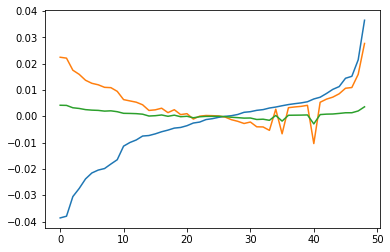

In [92]:
plt.plot(comp['mod_0_on_mod_0'])

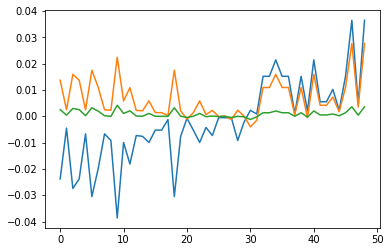

In [93]:
plt.plot(comp['mod_1_on_mod_0'])

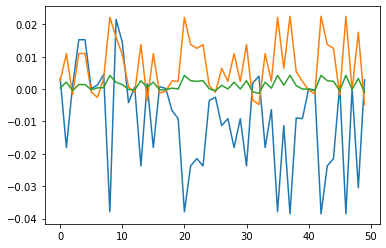

In [94]:
plt.plot(comp['mod_2_on_mod_0'])